<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Flood_NISAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAR Application: Flooding
### I. How to create SAR quicklook images of flooding?

* Useful Products: HH, HV, and VV (if possible) polarizations
  * In forests, HH tends to pentrate further than VV. HV is more sensitive to volume scattering or to vegetation cover and biomass.
* Useful Wavelengths: L, S, C
  * Generally, longer wavelengths have greater penetration through the vegetation canopy, and the area's composition of tall and short flooded vegetation can help determine the best wavelength to use. For example, in a flooded forest, L-Band  is suited to detect inundation beneath the canopy. C and S band have reduced penetration capabilities but may be better suited for less densely vegetated areas of different conditions such as "leaf off." C-Band is better for patty rice cultivation and herbaceous wetlands.
* Instructions to View: Pauli decomposition for quad-pol or HH/HV, VV/VH for dual-pol images
* How does the user know the SAR data contains and is sensitive to flooding:
  * flood stage and flood area extent during acquisition, flooded grasses vs. flooded trees vs. open water, and the number of flood days

### II. How to interpret L-Band SAR images of flooding?
In RGB images, the overlay of the intensities of different polarization channels allows users to visually classify a scene by its backscattering mechanism. For example, surface scattering shows a strong HH and VV return, volume scattering has a strong HV return, and double-bounce scattering has a strong HH return. In the RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests or vegetated fields. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter. SAR data's advantage is its ability to penetrate the vegetation canopy and its sensitivity to standing water under vegetation.

To identify areas of flooding, compare the SAR RGB image before and after the flood. Co-pol signal is relatively stronger in inundated areas owing to double-bounce. L-band brightness increases over flooded forests and tall vegetation, while short vegetation and open water will appear dark.

-----------------------------------
Backscatter Mechanisms:
- Specular Scattering: when there is a smooth surface, such as open water. In specular scattering, the signal scatters away from the radar. As a result, open water appears dark in the image.
- Rough Scattering: slight roughness, where some but not all of the signal scatters away from the radar. This could be due to wind roughening or some vegetation.
- Double Bounce: most of the signal is returned to the sensor, and these areas appear very bright in the image. This occurs in areas of flooded vegetation because of the interaction of the smooth water surface and vertical vegetation. Two smooth surfaces creating right angles.

## SAR Example: Hurricane Florence Flooding
Hurricane Florence was a category 4 hurricane from August 31 through September 18, 2018 that caused significant freshwater and storm surge flooding along the southeastern coast of the Carolinas. From September 17 through September 23, UAVSAR (L-Band airborne radar) flew five times over the Pee Dee River in South Carolina to collect data during and after the hurricane. This Notebook will look at flooding changes during these acquistions.

The content of this notebook is as follows:
1. [Running the Notebook](#s1)
2. [Compare HH, HV, and VV of September 17 vs September 23 2018](#s2)
3. [Coherence](#s3)
4. [Optional: Google Earth Engine Pauli Decomposition RGB (Interactive Map & Slideshow)](#s4)

<a name="s1"></a>
## 1. Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are installed in the cell below. Downloading new python packages to this environment may take a few minutes to complete.


In [1]:
# Installing rasterio to Google Colab environment. May take a few minutes to run.
!pip install rasterio --quiet

import numpy as np              # Numeric and mathematic functions
import rasterio as rio          # Read and write geospatial raster data
import matplotlib.pyplot as plt # Plotting, making graphs
from rasterio.plot import show  # Rasterio plotting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.0 MB/s eta 0:00:00


### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs.


In [2]:
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18064_002_180917_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_18069_007_180923_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Flood/peedee_15100_180920_180922_L090HH_01_subset.cor.tif --quiet

<a name="s2"></a>
## 2. Compare HH, HV, and VV during flooding (September 17, 2018 vs. September 23, 2018)

Read in the data


In [3]:
def read_file(path):
    with rio.open(path) as ds:
        band = ds.read(1)
    return band

HH17 = read_file('peedee_15100_18064_002_180917_L090HHHH_CX_01.grd.tif')
HV17 = read_file('peedee_15100_18064_002_180917_L090HVHV_CX_01.grd.tif')

HH23 = read_file('peedee_15100_18069_007_180923_L090HHHH_CX_01.grd.tif')
HV23 = read_file('peedee_15100_18069_007_180923_L090HVHV_CX_01.grd.tif')

## Remove nodata values (-999)
HH17[HH17<=0] = np.nan
HV17[HV17<=0] = np.nan
HH23[HH23<=0] = np.nan
HV23[HV23<=0] = np.nan

Plot HH, HV, and VV polarizations for September 17th and September 23rd.

The top rows shows the polarizations for September 17th and the boottom row shows September 23rd over a portion of the PeeDee River, flooding around the river, and adjacent agricultural fields. These plots help show changes between the two dates and differences in each polarizations' sensitivity to flooding. Intepretation: Flooded vegatation & agricultural fields. Inundated vegetation vs open water.


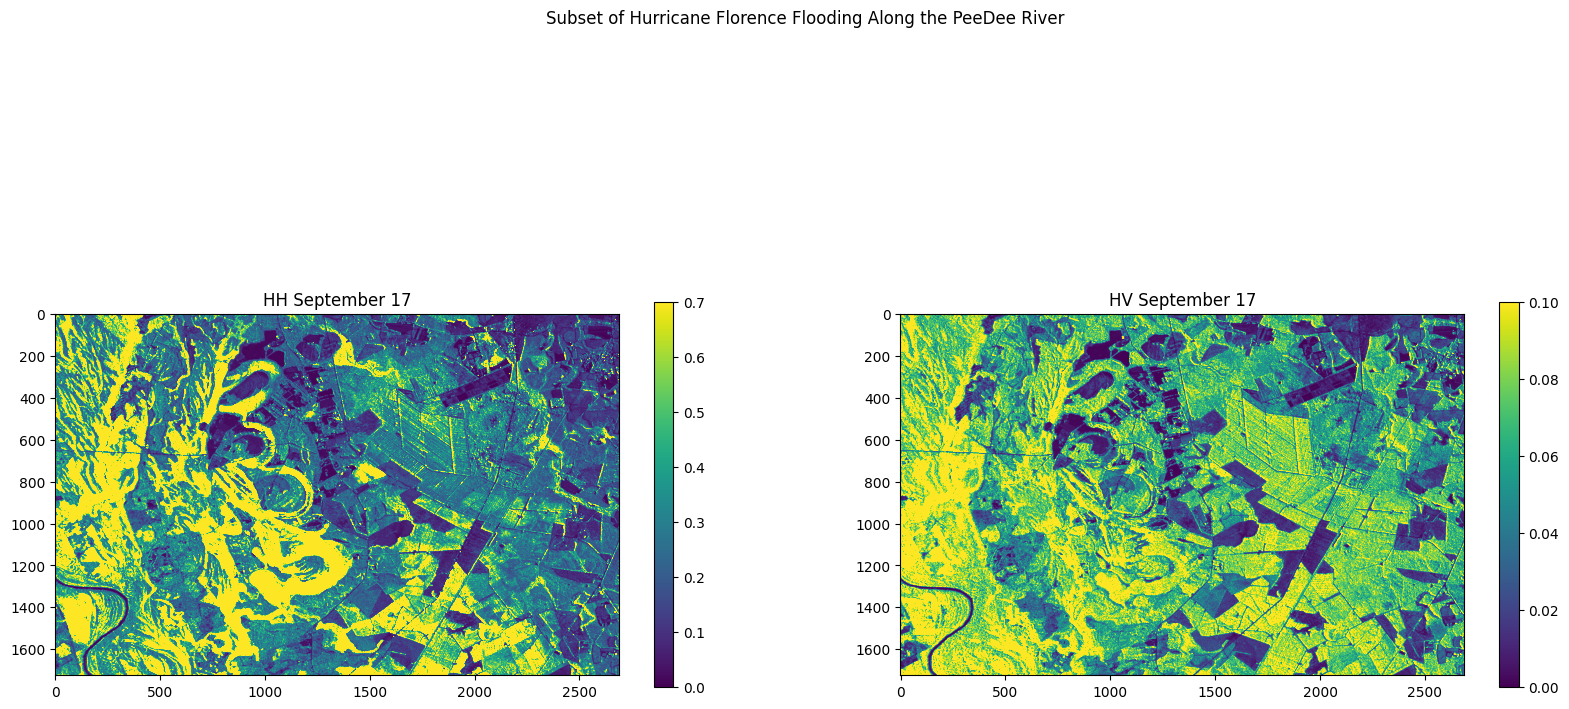

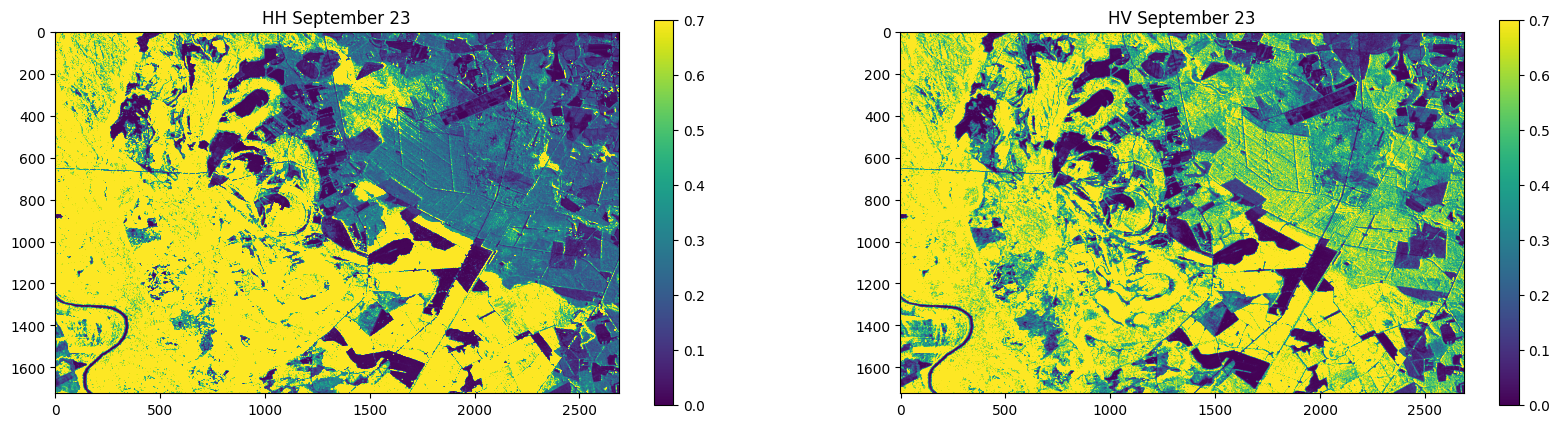

In [10]:
## September 17
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

HH17_plt = ax1.imshow(HH17, vmin=0, vmax=0.7)
ax1.set_title('HH September 17')
fig.colorbar(HH17_plt, ax=ax1, shrink=0.5)

HV17_plt = ax2.imshow(HV17, vmin=0, vmax=0.1)
ax2.set_title('HV September 17')
fig.colorbar(HV17_plt, ax=ax2, shrink=0.5)

# Add general map title
fig.suptitle("Subset of Hurricane Florence Flooding Along the PeeDee River")

## September 23
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))

HH23_plt = ax3.imshow(HH23, vmin=0, vmax=0.7)
ax3.set_title('HH September 23')
fig.colorbar(HH23_plt, ax=ax3, shrink=0.5)

HV23_plt = ax4.imshow(HV23, vmin=0, vmax=0.1)
ax4.set_title('HV September 23')
fig.colorbar(HH23_plt, ax=ax4, shrink=0.5)


Now, plot HH and HV Histograms

HV has a narrower range concentrated at lower values, while HH shows a lower spread but a higher concentration of lower values on September 23 vs September 17.


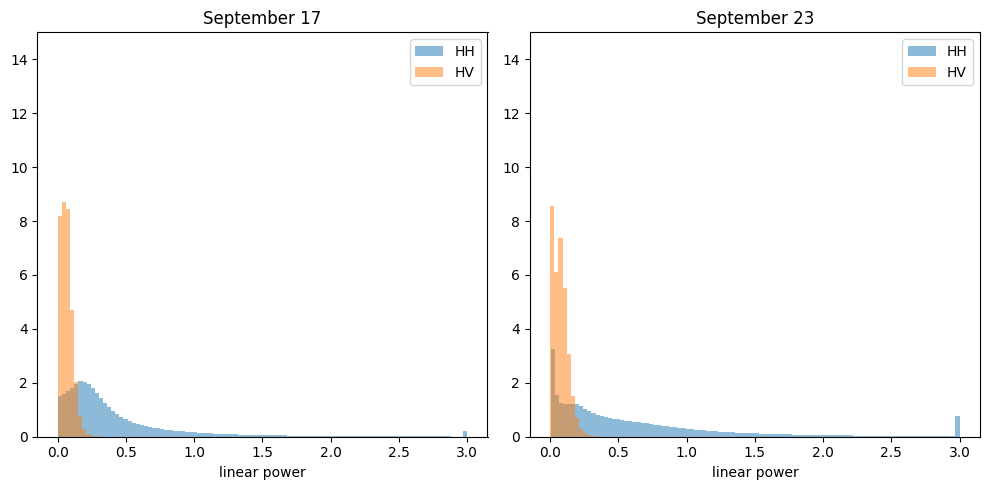

In [12]:
n = 100
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)

polarization = ['HH', 'HV']

ax1.hist(np.clip(HH17.ravel(),-1,3), density=True, bins=n, alpha=0.5, label='HH')
ax1.hist(np.clip(HV17.ravel(),-1,3), density=True, bins=n, alpha=0.5, label='HV')
ax1.set_title('September 17')
ax1.legend(prop={'size': 10})
ax1.set_xlabel('linear power')
ax1.set_ylim(0, 15)

## Clamp to same axis as Sept 17
ax2.hist(np.clip(HH23.ravel(),-1,3), density=True, bins=n, alpha=0.5, label='HH')
ax2.hist(np.clip(HV23.ravel(),-1,3), density=True, bins=n, alpha=0.5, label='HV')
ax2.set_title('September 23')
ax2.legend(prop={'size': 10})
ax2.set_xlabel('linear power')
ax2.set_ylim(0, 15)

fig.tight_layout()
plt.show()

<a name="s3"></a>
## 3. Coherence

Instructions to View: Grayscale showing coherence 0-1; use the same scale for "before" and "after" image to facilitate comparison. Compare image pairs with increasing temporal separation up to a maximum that is determined empirically. After a number of days, the entire image is decorrelated.

Interpretation: Close to black: open water bodies that decorrelate the fastest. Dark gray= decorrelated due to flood. Mid-gray and white = areas where water level changes are not detected by SAR. This could still be saturated soil.

UAVSAR data product page: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=peedee_15100_18067-005_18068-005_0002d_s01_L090_01#data


Text(0.5, 1.0, 'Coherence from September 20 to September 22 (HH)')

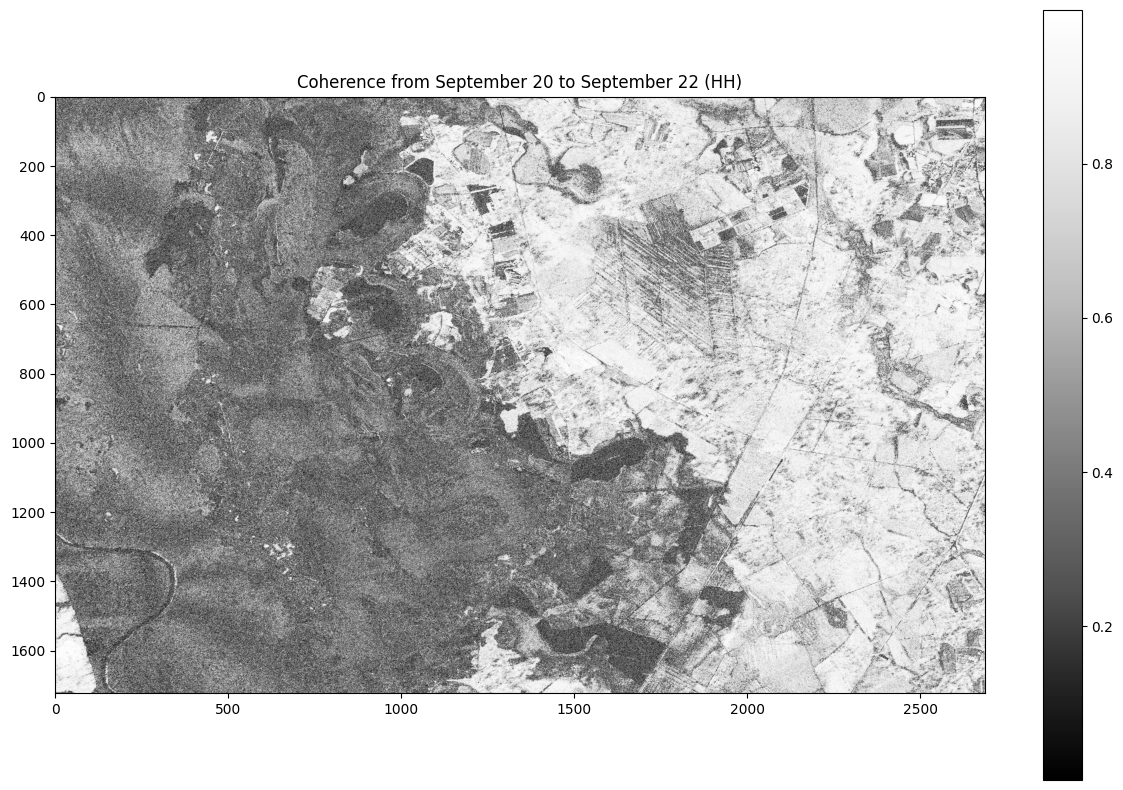

In [13]:
coherence = read_file("peedee_15100_180920_180922_L090HH_01_subset.cor.tif")
coherence[coherence == 0] = np.nan

fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(coherence, cmap="Greys_r")
plt.colorbar()
plt.title('Coherence from September 20 to September 22 (HH)')

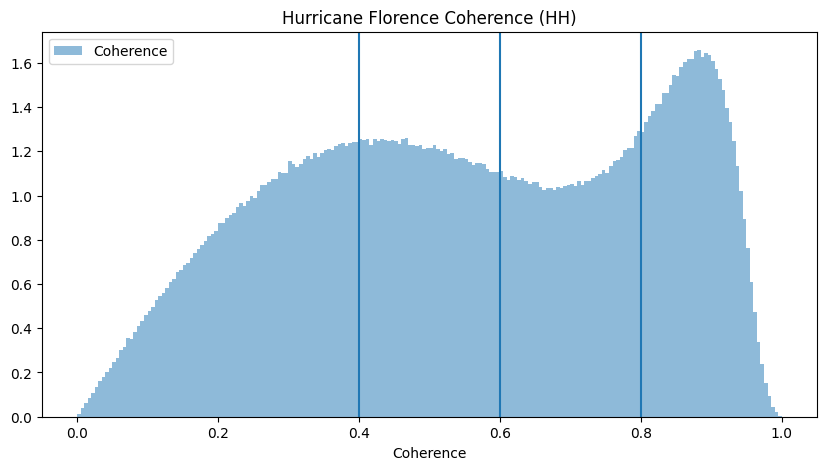

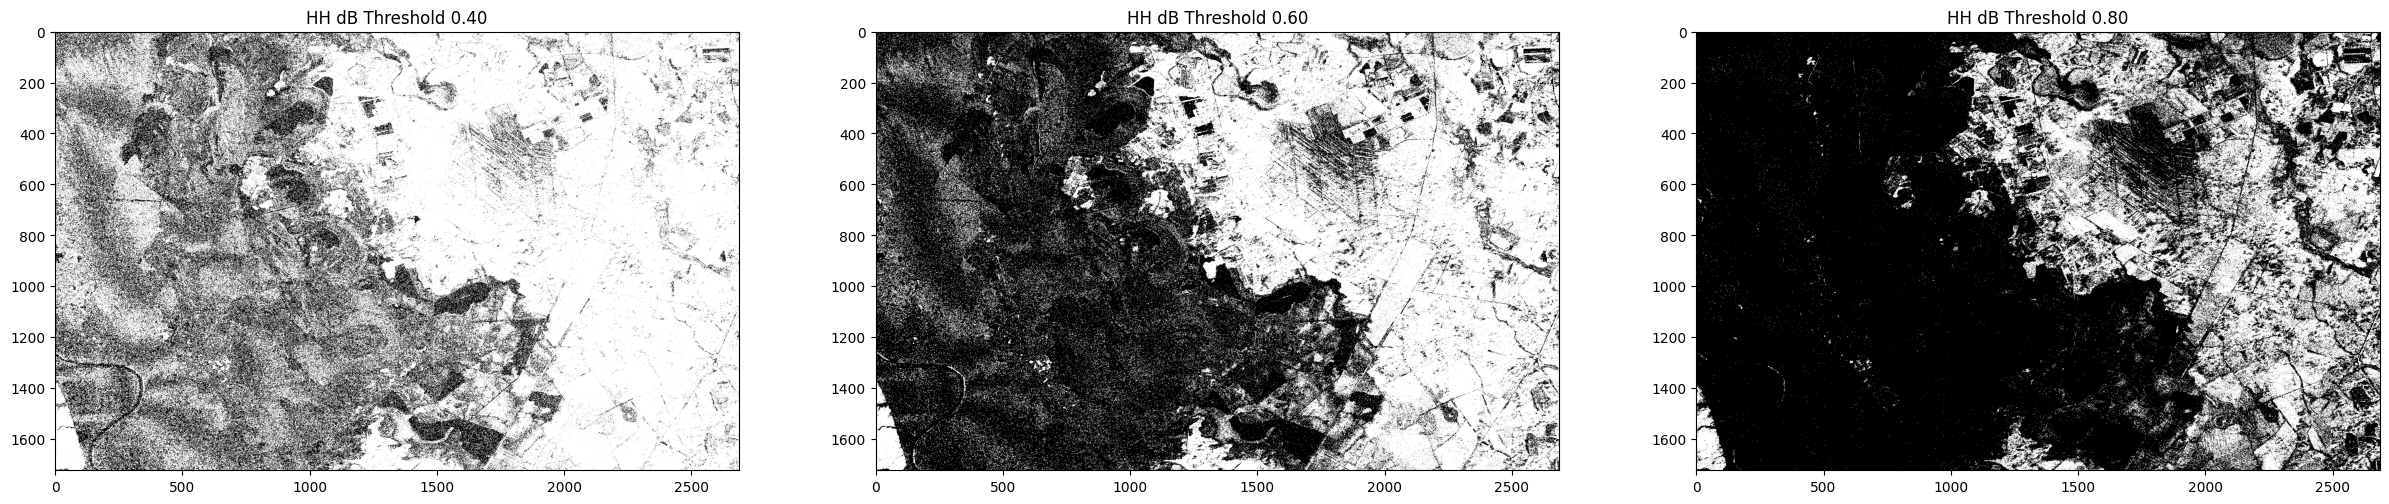

In [14]:
## Coherence Histogram
n = 200
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(coherence.ravel(), density=True, bins=n, alpha=0.5, label='Coherence')
ax.set_title('Hurricane Florence Coherence (HH)')
ax.legend(prop={'size': 10})
ax.set_xlabel('Coherence')

xpoints = [0.4, 0.6, 0.8]
for p in xpoints:

    plt.axvline(p,  label='threshold values')
plt.show()

## Thresholding
N=3
thresh_arr = np.linspace(0.4,0.8, N)
fig, ax = plt.subplots(1, N, figsize=(30, 15))
for ax, thresh in zip(ax.ravel(), thresh_arr):
    ax.imshow(coherence < thresh, cmap="Greys")
    ax.set_title(f'HH dB Threshold {thresh:1.2f}')

## Data Download
Download UAVSAR line peedee_15100 https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

UAVSAR website: https://uavsar.jpl.nasa.gov


## Other Resources
NISAR Flood Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/5_NISAR_Applications_Floods.pdf

CEOS Document - A Layman’s Interpretation Guide to L-band and C-band Synthetic Aperture Radar data:
http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf

ESA Radar Courses:
https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses

ESA Pauli Decomposition: https://earth.esa.int/documents/653194/656796/DIY_2_Representations_of_polarimetric_information.pdf

SERVIR Biomass:  https://www.servirglobal.net/Global/Articles/Article/2674/sar-handbook-comprehensive-methodologies-for-forest-monitoring-and-biomass-estimation

NASA ARSET: SAR for Flood Mapping (Slides: https://appliedsciences.nasa.gov/sites/default/files/SAR_Part1.pdf, Lecture Videos: https://appliedsciences.nasa.gov/join-mission/training/english/arset-sar-landcover-applications)

NASA ARSET: Introduction to SAR Remote Sensing (https://appliedsciences.nasa.gov/join-mission/training/english/arset-introduction-synthetic-aperture-radar)


## References
US Department of Commerce, NOAA. “Historical Hurricane Florence, September 12-15, 2018.” National Weather Service, NOAA's National Weather Service, www.weather.gov/mhx/Florence2018.

https://www.sciencedirect.com/science/article/pii/S0034425712004257

https://ui.adsabs.harvard.edu/abs/2019AGUFMIN53C0755M/abstract

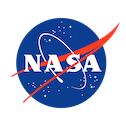

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged.